In [2]:
import pandas as pd 

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    "n_neighbors": [3, 5, 7, 11, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski"],
    "p": [1, 2],              
    "algorithm": ["auto"],
}

scoring = {
    "f1": make_scorer(f1_score, pos_label= 1),
    "precision": make_scorer(precision_score, pos_label= 1),
    "recall": make_scorer(recall_score, pos_label=1),
    "precisionF" : make_scorer(precision_score, pos_label=0),
}

kf = GroupKFold(n_splits=5)
models_cv = RandomizedSearchCV(KNeighborsClassifier(n_neighbors=5),
    param_distributions=param_grid,
    n_iter=50,
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    scoring=scoring,
    refit='precision')

models_cv.fit(X_train, y_train, groups=groups)

best_model = models_cv.best_estimator_ 
print("Best score:", models_cv.best_score_)
print("Best params:", models_cv.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/janma/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=uniform; total time=   0.2s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] E

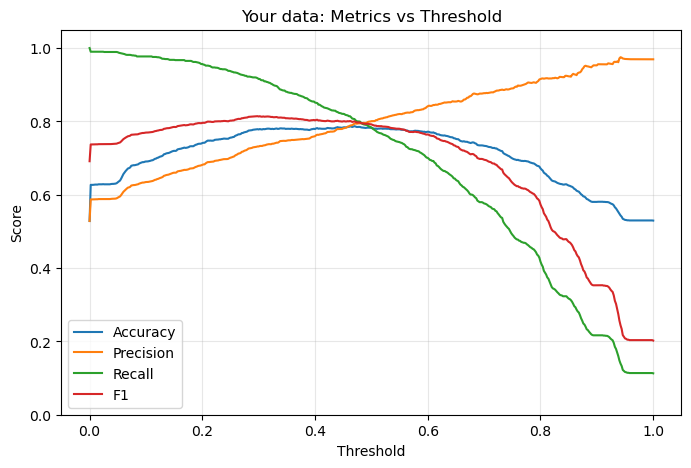

In [7]:
y_2 = best_model.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_2, title="Your data: Metrics vs Threshold")

In [8]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_2 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 ≥ 0.80)")
y_pred_thr = (y_2 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.230  (F1 ≥ 0.80)
Precision/Recall/F1 @ thr: 0.6945320715036803 0.9442458899213724 0.8003635262041805
[[ 668  581]
 [  78 1321]]


In [9]:
from pathlib import Path
import joblib

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [10]:
bundle = {
    "model": best_model,            
    "threshold": thr_star,              
}

joblib.dump(bundle, ARTS / "merged_knn.pkl")
print("Saved →", ARTS / "merged_knn.pkl")

Saved → ../../saved-models/merged/merged_knn.pkl
